In [1]:
# disable eager execution
import tensorflow as tf

from architectures.fc_models import AutoEncoder, ResidualAutoEncoder
from tensorflow.keras.optimizers.legacy import Adam
tf.config.run_functions_eagerly(True)
import os
os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'

2024-04-02 14:44:52.705383: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-02 14:44:52.894532: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-02 14:44:52.894579: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-02 14:44:52.934832: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-02 14:44:53.047654: I tensorflow/core/platform/cpu_feature_guar

In [2]:
BINARY_SIZE = 512
PATCH_SIZE = 8
STEPS = 16

In [3]:
network = ResidualAutoEncoder(binary_size=BINARY_SIZE, patch_size=PATCH_SIZE, steps=STEPS)

2024-04-02 14:44:56.975127: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-02 14:44:57.162114: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-02 14:44:57.162678: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-02 14:44:57.166727: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-02 14:44:57.167272: I external/local_xla/xla/stream_executor

In [6]:
# load the model
network(tf.random.normal((1, PATCH_SIZE *PATCH_SIZE *3)))
network.load_weights('residual_autoencoder_fully_connected_512.h5')  

In [7]:
# pull cifar10 data
from keras.datasets import cifar10
import numpy as np

(x_train, y_train), (x_test, y_test) = cifar10.load_data()
# append the data
x_train = np.append(x_train, x_test, axis=0)        

In [8]:
x_train = tf.image.extract_patches(x_train, sizes=[1, PATCH_SIZE, PATCH_SIZE, 1], strides=[1, PATCH_SIZE, PATCH_SIZE, 1], rates=[1, 1, 1, 1], padding='VALID')

In [9]:
# bring x_train to -1 to 1
x_train = tf.divide(tf.cast(x_train, tf.float32), 127.5) - 1
# flatten the data
x_train = tf.reshape(x_train, [-1, PATCH_SIZE*PATCH_SIZE*3])

In [10]:
network.compile(optimizer=Adam(learning_rate=0.0001), loss='mse')

In [8]:
tf.config.run_functions_eagerly(False)
network.fit(x_train, x_train, epochs=30, shuffle=True, batch_size=128)

Epoch 1/30


2024-04-02 11:56:14.996900: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


7500/7500 [==============================] - 211s 27ms/step - loss: 0.3898
Epoch 2/30
7500/7500 [==============================] - 206s 27ms/step - loss: 0.7594
Epoch 3/30
7500/7500 [==============================] - 202s 27ms/step - loss: 1.1006
Epoch 4/30
7500/7500 [==============================] - 207s 28ms/step - loss: 1.4138
Epoch 5/30
7500/7500 [==============================] - 205s 27ms/step - loss: 2.0425
Epoch 6/30
7500/7500 [==============================] - 215s 29ms/step - loss: 1.8686
Epoch 7/30
7500/7500 [==============================] - 227s 30ms/step - loss: 2.2447
Epoch 8/30
7500/7500 [==============================] - 229s 31ms/step - loss: 2.3833
Epoch 9/30
7500/7500 [==============================] - 228s 30ms/step - loss: 2.1968
Epoch 10/30
7500/7500 [==============================] - 220s 29ms/step - loss: 2.4434
Epoch 11/30
7500/7500 [==============================] - 221s 29ms/step - loss: 2.9744
Epoch 12/30
7500/7500 [==============================] - 220s 2

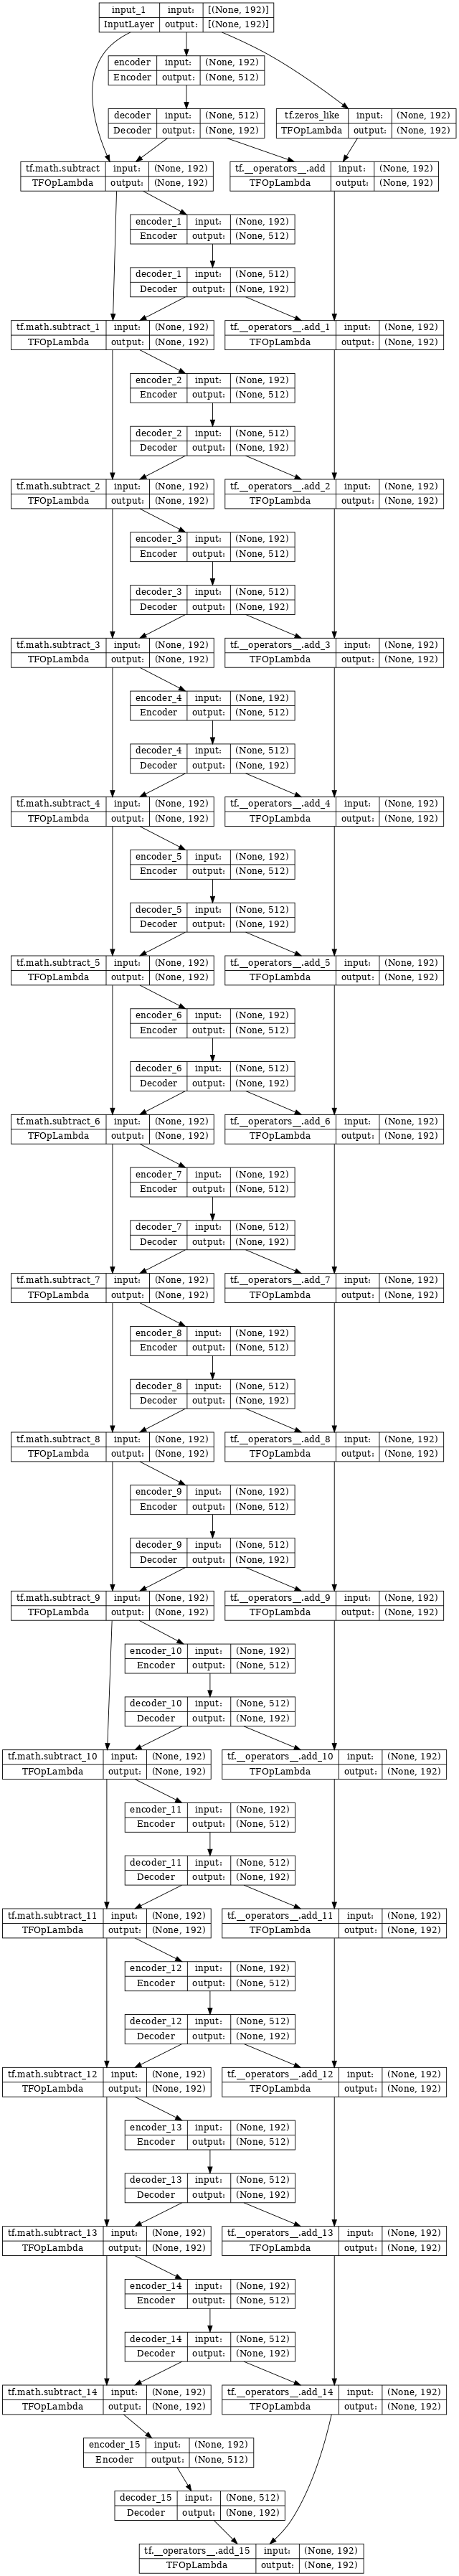

In [9]:
tf.keras.utils.plot_model(network.build_graph(), show_shapes=True, dpi=64, expand_nested=True, show_layer_activations=True)

In [10]:
network.summary()

Model: "residual_auto_encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Encoder)           (None, 512)               886272    
                                                                 
 encoder_1 (Encoder)         (None, 512)               886272    
                                                                 
 encoder_2 (Encoder)         (None, 512)               886272    
                                                                 
 encoder_3 (Encoder)         (None, 512)               886272    
                                                                 
 encoder_4 (Encoder)         (None, 512)               886272    
                                                                 
 encoder_5 (Encoder)         (None, 512)               886272    
                                                                 
 encoder_6 (Encoder)         (None, 512)     

1/1 [==============================] - 0s 72ms/step


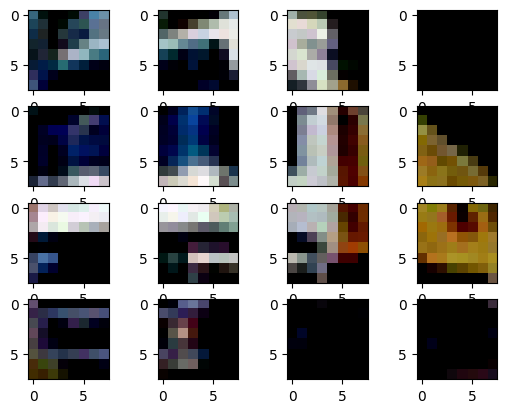

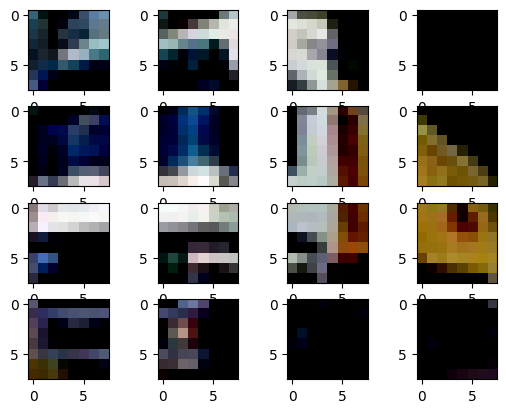

In [16]:
output = np.zeros((PATCH_SIZE, PATCH_SIZE, 3))
input_patch = x_train[16:32]

output = network.predict(input_patch)

import matplotlib.pyplot as plt

# display a 4x4 grid of images
fig, axs = plt.subplots(4, 4)
for i in range(4):
    for j in range(4):
        axs[i, j].imshow(np.clip(output[i * 4 + j] ,0 ,1).reshape(PATCH_SIZE, PATCH_SIZE, 3))

plt.show()

fig, axs = plt.subplots(4, 4)
for i in range(4):
    for j in range(4):
        axs[i, j].imshow(np.clip(input_patch[i * 4 + j], 0, 1).reshape(PATCH_SIZE, PATCH_SIZE, 3))

In [12]:
patches = []
input_value = x_train[5:6]
for i in range(STEPS):
    input_layer = tf.keras.layers.Input(shape=(PATCH_SIZE * PATCH_SIZE * 3,))
    encoder = tf.keras.models.Model(inputs=input_layer, outputs=network.encoders[i].call(input_layer))

    bits = encoder.predict(input_value)

    input_layer = tf.keras.layers.Input(shape=(BINARY_SIZE,))
    decoder = tf.keras.models.Model(inputs=input_layer, outputs=network.decoders[i].call(input_layer))

    output = decoder.predict(bits)
    patches.append(output)

    input_value = input_value - output

patches = np.array(patches).reshape(-1, PATCH_SIZE, PATCH_SIZE, 3)

1/1 [==============================] - 0s 78ms/step


In [13]:
patches_copy = patches.copy()
x_train = np.clip(x_train, -1, 1)

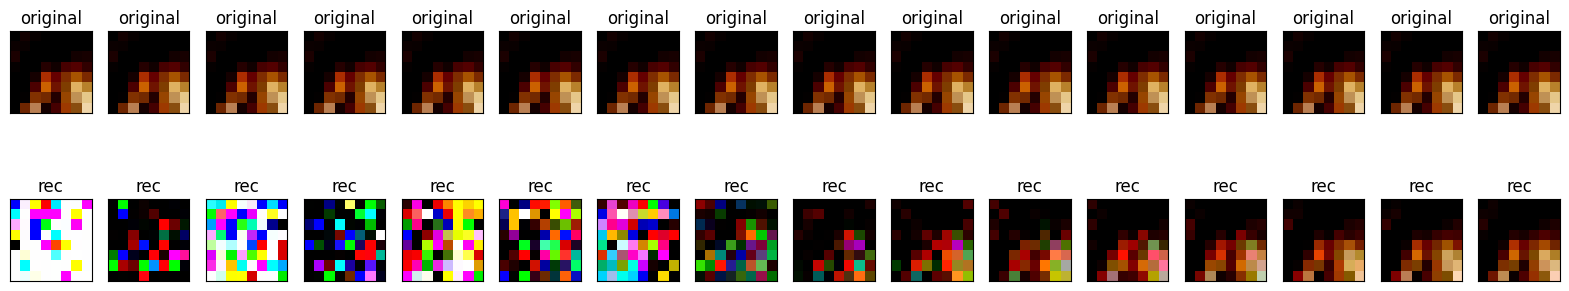

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 4))
reconstructed = np.zeros((PATCH_SIZE, PATCH_SIZE, 3))

for i in range(STEPS):
    # display original
    ax = plt.subplot(2, STEPS, i + 1)
    plt.imshow(np.clip(x_train[5], 0, 1).reshape(PATCH_SIZE, PATCH_SIZE, 3))
    plt.title("original")
    # plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, STEPS, i + 1 + STEPS)

    reconstructed = patches_copy[i] + reconstructed
    plt.imshow(np.clip(reconstructed, 0, 1))
    plt.title("rec")
    # plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

In [19]:
from metrics import psnr_hvs

PATCH_SIZE=8

x_sample = x_train[5:6]

x_sample = x_sample.reshape(-1, PATCH_SIZE, PATCH_SIZE, 3)
print(x_sample.shape)
x_sample = np.clip(x_sample.astype('float32'), 0, 1)

reconstructed = reconstructed.reshape(-1, PATCH_SIZE, PATCH_SIZE, 3)
print(reconstructed.shape)
reconstructed = np.clip(reconstructed.astype('float32'), 0, 1)
print("A")
psnr_hvs_val = psnr_hvs.compute_psnr_hvs(x_sample, reconstructed)

AttributeError: EagerTensor object has no attribute 'reshape'. 
        If you are looking for numpy-related methods, please run the following:
        tf.experimental.numpy.experimental_enable_numpy_behavior()
      

In [17]:
psnr_hvs_val

array([65.61347723])

In [15]:
# save network to disk
network.save_weights('residual_autoencoder_fully_connected_512.h5')

In [11]:
def pad_image(image: np.ndarray, patch_size: int):
    h, w, c = image.shape
    h_pad = (patch_size - (h % patch_size)) % patch_size
    w_pad = (patch_size - (w % patch_size)) % patch_size

    return np.pad(image, ((0, h_pad), (0, w_pad), (0, 0)), mode='constant', constant_values=0), h_pad, w_pad

In [12]:
def compress_image(image: np.ndarray, network: tf.keras.Model) -> tuple[np.ndarray, np.ndarray]:
    """
    Compress an image using the given network
    :param image: The image to compress
    :param network: The network to use for compression
    :return: The compressed image & the bits
    """
    patch_size = network.patch_size
    steps = network.steps

    print(image.shape)

    # pad the image
    image, h_pad, w_pad = pad_image(image, patch_size)
    
    print(image.shape)
    height, width, channels = image.shape
    no_patches_width = width // patch_size
    no_patches_height = height // patch_size
    
    # transform image to list with a single element
    image = tf.expand_dims(image, axis=0)

    image = tf.image.extract_patches(image, sizes=[1, patch_size, patch_size, 1], strides=[1, patch_size, patch_size, 1], rates=[1, 1, 1, 1], padding='VALID')
    image = tf.divide(tf.cast(image, tf.float32), 127.5) - 1
    image = tf.reshape(image, [-1, patch_size*patch_size*3])

    bits = []
    reconstructed_patches = []

    input_value = image
    for i in range(steps):
        input_layer = tf.keras.layers.Input(shape=(patch_size * patch_size * 3,))
        encoder = tf.keras.models.Model(inputs=input_layer, outputs=network.encoders[i].call(input_layer))

        bits.append(encoder.predict(input_value))

        input_layer = tf.keras.layers.Input(shape=(network.binary_size,))
        decoder = tf.keras.models.Model(inputs=input_layer, outputs=network.decoders[i].call(input_layer))

        output = decoder.predict(bits[i])
        input_value = input_value - output

    reconstructed_patches = network.predict(image)
    
    reconstructed_image = np.zeros((height, width, channels))
    for i in range(no_patches_height):
        for j in range(no_patches_width):
            patch = reconstructed_patches[i*no_patches_width+j].reshape(patch_size, patch_size, 3)
            print(i*patch_size, (i+1)*patch_size, j*patch_size, (j+1)*patch_size)
            reconstructed_image[i*patch_size:(i+1)*patch_size, j*patch_size:(j+1)*patch_size] = patch

    height = height - h_pad
    width = width - w_pad

    reconstructed_image = reconstructed_image[:height, :width]
    
    return reconstructed_image

In [13]:
# load an image
from PIL import Image

image = Image.open('ciob.png').convert('RGB')
image = np.array(image)


In [14]:
compressed = compress_image(image, network)

(467, 396, 3)
(472, 400, 3)
14/93 [===>..........................] - ETA: 0s

/home/cezar/micromamba/envs/disertatie/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


93/93 [==============================] - 6s 62ms/step
0 8 0 8
0 8 8 16
0 8 16 24
0 8 24 32
0 8 32 40
0 8 40 48
0 8 48 56
0 8 56 64
0 8 64 72
0 8 72 80
0 8 80 88
0 8 88 96
0 8 96 104
0 8 104 112
0 8 112 120
0 8 120 128
0 8 128 136
0 8 136 144
0 8 144 152
0 8 152 160
0 8 160 168
0 8 168 176
0 8 176 184
0 8 184 192
0 8 192 200
0 8 200 208
0 8 208 216
0 8 216 224
0 8 224 232
0 8 232 240
0 8 240 248
0 8 248 256
0 8 256 264
0 8 264 272
0 8 272 280
0 8 280 288
0 8 288 296
0 8 296 304
0 8 304 312
0 8 312 320
0 8 320 328
0 8 328 336
0 8 336 344
0 8 344 352
0 8 352 360
0 8 360 368
0 8 368 376
0 8 376 384
0 8 384 392
0 8 392 400
8 16 0 8
8 16 8 16
8 16 16 24
8 16 24 32
8 16 32 40
8 16 40 48
8 16 48 56
8 16 56 64
8 16 64 72
8 16 72 80
8 16 80 88
8 16 88 96
8 16 96 104
8 16 104 112
8 16 112 120
8 16 120 128
8 16 128 136
8 16 136 144
8 16 144 152
8 16 152 160
8 16 160 168
8 16 168 176
8 16 176 184
8 16 184 192
8 16 192 200
8 16 200 208
8 16 208 216
8 16 216 224
8 16 224 232
8 16 232 240
8 16 240 248

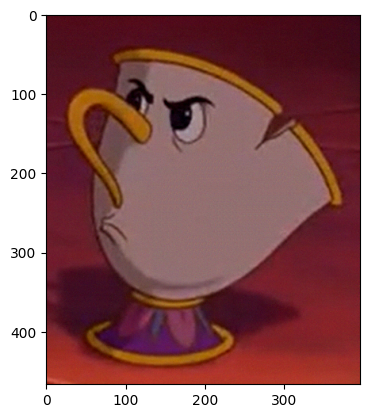

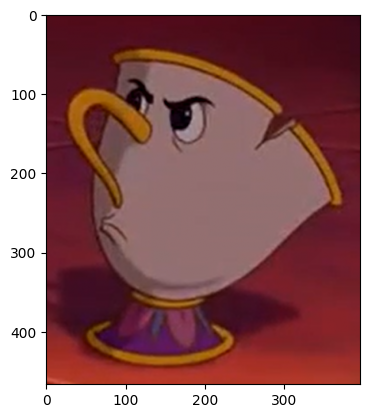

In [17]:
compressed_copy = np.clip((compressed + 1) / 2,0 ,1)
plt.imshow(compressed_copy)
plt.show()

plt.imshow(image / 255)
plt.show()


In [24]:
compressed_padded, _, _ = pad_image(compressed_copy, PATCH_SIZE)
image_padded, _, _ = pad_image(image, PATCH_SIZE)

In [25]:
psnr_hvs_val = psnr_hvs.compute_psnr_hvs((image_padded/ 255).reshape(-1, *image_padded.shape), compressed_padded.reshape(-1, *compressed_padded.shape))

(1, 472, 400)
X SHAPE ::  (1, 472, 400)
PREV SHAPE ::  (1,)
X SHAPE ::  (1, 472, 400)
PREV SHAPE ::  (1,)


/home/cezar/micromamba/envs/disertatie/lib/python3.11/site-packages/psnr_hvsm/numpy/psnr_hvsm.py:50: RuntimeWarning: invalid value encountered in divide
  var = np.where(var != 0.0, (vari(tiles[..., :qh, :qw]) +


In [26]:
psnr_hvs_val

array([81.13809217])